In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [11]:
class survivor:

    def __init__(self, player_name, player_strategy):
        """Defines Survivor strategy; selfless, selfish, selfless-leaning, selfish-leaning, and standard"""
        #self.survivor_num = num_survivors + 1
        self.player_name = player_name
        self.player_strategy = player_strategy

        self.is_injured = False #defines if you hav been injured
        self.gens_completed = 0
        self.score = 0
        self.hooks = 0
        self.r = .1

        if player_strategy == "STANDARD":
            self.help_p = .5 #probability to help
            self.STRATEGIES = {"Chased": [1/3, 1/3, 1/3], "Save": [1/2, 1/2], "Pop": [1/2, 1/2], "Help": [1/2, 1/2]}
        
        if player_strategy == "SELFLESS":
            self.help_p = 1 #probability to help
            self.STRATEGIES = {"Chased": [.1, .7, .2], "Save": [.95, 0.05], "Pop": [.8, .2], "Help": [1, 0]}

        if player_strategy == "SELFLESS-LEANING":
            self.help_p = .75 #probability to help
            self.STRATEGIES = {"Chased": [.2, .5, .3], "Save": [.7, .3], "Pop": [.6, .4], "Help": [.7, .3]}
        
        if player_strategy == "SELFISH":
            self.help_p = 0 #probability to help
            self.STRATEGIES = {"Chased": [.7, .1, .2], "Save": [0.05, .95], "Pop": [.2, .8], "Help": [0, 1]}

        if player_strategy == "SELFISH-LEANING":
            self.help_p = .25 #probability to help
            self.STRATEGIES = {"Chased": [.5, .2, .3], "Save": [.3, .7], "Pop": [.4, .6], "Help": [.3, .7]}
            
    def reset(self):
        self.is_injured = False 
        self.gens_completed = 0
        self.score = 0
        self.hooks = 0
        self.r = .1

    '''
    def __repr__(self):
        print(self.player_name + " Strategy: " + self.player_strategy )
        print("Score: " + str(self.score))
        print(self.score)
    
    
    def __eq__(self, other):
        if self.player_name == other.player_name:
            return True
        else: 
            return False
    '''

    def strategicMove(self, situation):
        if situation == "Chased":
            return np.random.choice(["Run", "Obstacle", "Stun"],1, self.STRATEGIES["Chased"])[0]
        if situation == "Save":
            return np.random.choice(["Rescue", "Leave"],1, self.STRATEGIES["Save"])[0]
        if situation == "Pop":
            return np.random.choice(["Continue", "Leave"],1, self.STRATEGIES["Pop"])[0]
        if situation == "Help":
            return np.random.choice(["Heal", "Ignore"],1, self.STRATEGIES["Help"])[0]
        



    def request_help(self, game):
        """requests help from a particular survivor"""

        avail_players = game.free_survivors
        random.shuffle(avail_players)
        for survivor in avail_players:
            move = survivor.strategicMove("Help")
            if move == "Heal":
                self.is_injured == False
                survivor.score += 10
                return



    def pick_gen(self, avail_gens):
        choice = random.choice(avail_gens)
        return choice


    def nextMove(self, game):
        """Chooses whether to pick a generator to work on, or go and help a teammate"""

        if self.is_injured == True:
            self.request_help(game)
            if self.is_injured == False:
                return ("Hide", self)
        
        if all( (s==0 or s==1) for s in column(game.hook_set, 0)) !=True: # not empty
            help_decision = np.random.binomial(1, self.help_p)
            if help_decision == 1: #agrees to help
                #pick survivor to help
                hooked_survivors = [survivor for survivor in column(game.hook_set, 0) if survivor != 0 and survivor != 1]
                surv_choice = random.choice(hooked_survivors)
                return ("Hooked", [self, surv_choice])
        
        #pick generator
        if game.gens_fixed < 5:
            available_gens = [i for i in range(7) if 0 in game.gen_set[i]] # gives list of generators with available spot
            #print("hello")
            #print(game.gen_set)
            #print(available_gens)
            return ("Fix Gen", self, self.pick_gen(available_gens))
        else:# nothing left to do
            return ("Hide", self)

In [12]:
class killer:

    def __init__(self):
        """Defines Killer"""
        self.busy = False
        self.camp_p = .5

    def check_gen(self, gen_set):
        """"""
        choice = np.random.choice(range(len(gen_set)))
        return choice


    def nextMove(self, game):
        """takes in game opject"""
        gen_set = game.gen_set
        if self.busy == True:
            return ("Nothing", None)
        else:
            #check generator
            choice = self.check_gen(gen_set)
            picked_gen = gen_set[choice]
            found_survivors = [surv for surv in picked_gen if surv != 0 and surv != 1]
            if len(found_survivors) != 0:
                if len(found_survivors) == 1:
                    return ("Chase", found_survivors)
                else:
                    return ("Chase", found_survivors[:-1])

        avail_players = game.free_survivors
        random.shuffle(avail_players)
        for survivor in avail_players:
            search = np.random.binomial(1,survivor.r)
            if search == 1:
                return ("Chase", [survivor] )
        return ("Nothing", None)


In [104]:
class dbd:
    """Defines state of game"""
   
    def __init__(self, killer, survivors):
        self.gen_set = np.zeros((7,3), dtype=survivor) # 0 if not in use, 1 if fixed, player_object if being worked on
        self.gen_vals = np.zeros((7)) # 0 if not fixed, 3 if fixed
        self.hook_set = np.zeros((4,2), dtype=survivor) # 0 if not in use, 1 if used, player_object if hooked
        self.trap_door_open = False 

        self.num_rounds = 0
        self.players = [survivors[0], survivors[1], survivors[2], survivors[3]]
        self.free_survivors = survivors
        self.dead_survivors = []
        self.killer = killer

        self.survivors_alive = 4
        self.gens_fixed = 0
        self.canEscape = 2 # After all generators fixed, players must wait 2 rounds before being able to escape

#------------------------------------------------------------

    
    def __repr__(self):
        print("Round Number: " + self.num_rounds)
        print("Survivors Alive: " + self.survivors_alive)
        print("Generators Fixed: " + self.gens_fixed)

#------------------------------------------------------------

    def lookForTrapDoor(self, player):
        Found = np.random.binomial(1, 0.1)
        if Found:
            player.score += 50
        player.r = min(.9,player.r+.1)
        return (Found == 1)

#------------------------------------------------------------

    def fix_generator(self, player, choice):
        """accepts generator pick from survivor"""
        if player not in self.gen_set[choice]:
            pos = np.where(self.gen_set[choice] == 0)[0]
            if len(pos) == 0: return
            pos = pos[0]
            self.gen_set[choice][pos] = player

        
        workOnGenerator = True

        skillCheck = np.random.binomial(1, 0.5)
        if skillCheck:
            popGenerator = np.random.binomial(1, 1/3)
            if popGenerator:
                decision = player.strategicMove("Pop")
                workOnGenerator = (decision == "Continue")
                if workOnGenerator:
                    player.r = min(.9,player.r+.3)
                else:
                    pos = np.where(self.gen_set[choice] == player)
                    self.gen_set[choice][pos] = 0
                    return

        if workOnGenerator:
            self.gen_vals[choice] += 1

        if self.gen_vals[choice] == 5:
            self.gens_fixed += 1
            p=self.gen_set[choice,:]
            for i in range(len(p)):
                if p[i]!=0:
                    p[i].score+=10
                self.gen_set[choice][i] = 1

#------------------------------------------------------------

    def hooked(self, players):
        pos = np.where(self.hook_set[:,0] == players[1])[0][0]
        killerCamping =  all([self.hook_set[pos][1] != 0, self.hook_set[pos][1] != 1])
        
        decision = players[0].strategicMove("Save")
        if not killerCamping or decision == "Rescue":
            self.hook_set[pos][0] = 0
            self.free_survivors.append(players[1])
            players[0].score += 25
            players[0].r = min(.9, players[0].r + .3)
            
        else: return

        self.killer.busy = False
        self.hook_set[pos][1] = 0

        return self.chase(players)

#------------------------------------------------------------

    def chase(self, players):


        chasedPlayers = players 

        numChased = len(players)

        if numChased == 1:
            probs = {"Obstacle": 0.3, "Stun": 0.05, "Run": 0.2}
        else:
            probs_1 = {"Obstacle": 0.8, "Stun": 0.2, "Run": 0.5}
            probs_2 = {"Obstacle": 0.3, "Stun": 0.9, "Run": 0.5}
        
        
        turn = 0
        for chasedPlayer in chasedPlayers:
            
            
            if turn == 0 and numChased > 1:
                probs = probs_1
            if turn == 1 and numChased > 1:
                probs = probs_2
            
            while(True): 

                playerStrat = chasedPlayer.strategicMove("Chased")
                chaseOutcome = np.random.binomial(1, probs[playerStrat])

                if chaseOutcome == 1: # Escaped
                    chasedPlayer.score += 30
                    break
                else:  # Hit by killer
                    if not chasedPlayer.is_injured: # First hit -> continue chase
                        chasedPlayer.is_injured = True
                        chasedPlayer.r = min(.9, chasedPlayer.r+.3)
                    else: 
                        i = random.randint(0,3)
                        self.hook_set[i][0] = chasedPlayer                        
                        for p in self.free_survivors:
                            if p == chasedPlayer: self.free_survivors.remove(p)

                        chasedPlayer.hooks += 1
                        
                        if chasedPlayer.hooks == 3:
                            # KILL Player
                            self.dead_survivors.append(chasedPlayer)
                            self.hook_set[i][0] = 1
                            self.hook_set[i][1] = 1
                            self.survivors_alive -= 1
                        else:    
                            camping = np.random.binomial(1, self.killer.camp_p)
                            if camping: 
                                self.hook_set[i][1] = self.killer
                                self.killer.busy = True
            turn=1


#------------------------------------------------------------


    def run_round(self):
        ''' Runs a single round of the game'''

        workingOnGen = column(self.gen_set, 0) + column(self.gen_set, 1) + column(self.gen_set, 2)
        

        # Killers and free survivors take turns to play in a random order
        avail_players = self.free_survivors + [self.killer]
        random.shuffle(avail_players)
        for player in avail_players:
            
            if self.survivors_alive == 1 and player != self.killer:
                TrapDoorFound = self.lookForTrapDoor(player)
                if TrapDoorFound: return ("Trap Door Found!", [player])

            if player in workingOnGen:
                scenario = ("Fix Gen", player, workingOnGen.index(player) % 7)
            else:           
                scenario = player.nextMove(self)

            if scenario[0] == "Chase":
                self.chase(scenario[1])
            elif scenario[0] == "Hooked":
                self.hooked(scenario[1])
            elif scenario[0] == "Fix Gen":
                self.fix_generator(scenario[1], scenario[2])
            else:
                continue

        if self.gens_fixed == 5:
            doorOpen = (self.canEscape == 0)
            if doorOpen: return ("Escaped Door!", self.free_survivors)
            else: self.canEscape -= 1

        if self.survivors_alive == 0:
            return ("Game Over!", None)
        
        self.num_rounds += 1
        for survivor in self.free_survivors:
            survivor.r = max(0.1,survivor.r-.1)

        return None
            
#------------------------------------------------------------


    def play(self):
        ''' Runs rounds until game is over '''
        Outcome = None
        while Outcome == None:
            Outcome = self.run_round()
            if self.num_rounds == 100: 
                return None
        self.payoff(Outcome)
        return Outcome
            

#------------------------------------------------------------


    def payoff(self, Outcome):
        ''' Takes list of survivors alive and rewards everyone accordingly '''
        if Outcome[0] == "Game Over!":
            return
        else:
            winners = Outcome[1]
            numWinners = len(winners)

            for d in self.dead_survivors:
                d.score += 0.5 * d.score
            for w in winners:
                w.score += numWinners * w.score

In [114]:
# Available startegies
STRATEGIES = ["SELFLESS", "SELFISH", "SELFLESS-LEANING", "SELFISH-LEANING", "STANDARD"]

stratScores = {"SELFLESS":[], "SELFISH":[], "SELFLESS-LEANING":[], "SELFISH-LEANING":[], "STANDARD":[]}
stratNumEscapes = {"SELFLESS":0, "SELFISH":0, "SELFLESS-LEANING":0, "SELFISH-LEANING":0, "STANDARD":0}


# Defines how players for each strtagey we will have for a particular game
playerSET = [[4, 0, 0, 0, 0],    # i.e. 4 SELFLESS players
             [0, 4, 0, 0, 0],
             [0, 0, 4, 0, 0],
             [0, 0, 0, 4, 0],
             [0, 0, 0, 0, 4],
             [1, 1, 1, 1, 1],   # One of them sits out each round
             [3, 1, 0, 0, 0],
             [1, 3, 0, 0, 0],
             [0, 0, 1, 3, 0],
             [0, 0, 3, 1, 0],
             [2, 2, 0, 0, 0],
             [0, 0, 2, 2, 0]]

TotalGamesPlayed = 0
print("Begin Games")
for playerDist in playerSET:
    
    print("================================================")
    # Initialize players
    ps = []
    playerNum = 1
    whosPlaying = "Players playing "
    for i in range(len(playerDist)):
        for j in range(playerDist[i]):
            playerName = "P" + str(playerNum)
            playerStrategy = STRATEGIES[i]
            ps.append(survivor(playerName, playerStrategy))
            playerNum += 1
            whosPlaying += playerName + ":" + playerStrategy + " "

    print(whosPlaying)
    print("----------------------------------------")
    #exit()

    K = killer()

    # Play 100 games of each player set
    for game_num in range(100):

        # If all strategies playing (5), make one sit out each game 
        if len(ps) > 4:
            playerSittingOut = game_num % 5 
            survivorPlayers = [ps[i] for i in range(len(ps)) if i != playerSittingOut]
        else:
            survivorPlayers = [ps[0], ps[1], ps[2], ps[3]]
        
        # Create new game and play through till the end
        match = dbd(K, survivorPlayers)
        Outcome = match.play()
        
        # Game stuck in infinite loop for some reason
        if Outcome == None: continue

        # Find out who survived based on outcome and Update their escape values
        final = Outcome[0]
        if final == "Game Over!":
            final += " No survivors"
        else:
            for p in Outcome[1]:
                final += " " + p.player_name
                stratNumEscapes[p.player_strategy] += 1 # Update num escapes for strategy
            final += " Escaped!"

        print(final)
    
        # Save scores and reset all players
        for p in match.players:
            stratScores[p.player_strategy].append(p.score)
            p.reset()
        
        TotalGamesPlayed +=1


Begin Games
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
----------------------------------------
Trap Door Found! P1 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door!

Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P3 P4 P5 Escaped!
Escaped Door! P1 P2 P4 P5 Escaped!
Escaped Door! P1 P2 P3 P5 Escaped!
Escaped Door! P1 P2 P4 P5 Escaped!
Escaped Door! P1 P2 P3 P5 Escaped!
Escaped Door! P2 P3 P4 P5 Escaped!
Escaped Door! P1 P2 P3 P5 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P3 P4 P5 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P2 P3 P4 P5 Escaped!
Escaped Door! P1 P2 P4 P5 Escaped!
Escaped Door! P1 P2 P3 P5 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P2 P3 P4 P5 Escaped!
Escaped Door! P1 P3 P4 P5 Escaped!
Escaped Door! P1 P2 P4 P5 Escaped!
Escaped Door! P1 P2 P3 P5 Escaped!
Escaped Door! P1 P2 P4 P5 Escaped!
Escaped Door! P1 P2 P3 P5 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P3 P4 P5 Escaped!
Escaped Door! P1 P2 P3 P5 Escaped!
Escaped Door! P2 P3 P4 P5 Escaped!
Escaped Door! P2 P3 P4 P5 Escaped!
Escaped Door! P1 P2 P3 P5 Escaped!
Escaped Door! P2 P3 

Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Escaped Door! P1 P2 P3 P4 Escaped!
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
----------------------------------------
Trap Door Found! P2 Esca

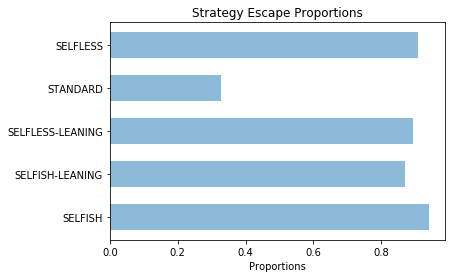

In [115]:
strats = list(stratNumEscapes.keys())
props = list(stratNumEscapes.values()) 
props = [val / TotalGamesPlayed for val in props]

plt.barh(strats, props, height = 0.6, align='center', alpha=0.5)
plt.xlabel('Proportions')
plt.title('Strategy Escape Proportions')

plt.show()

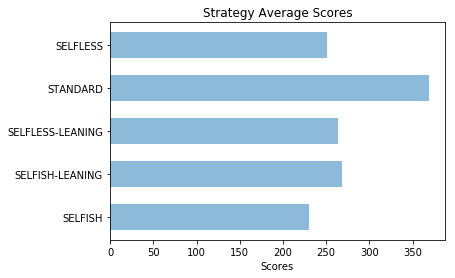

In [116]:
strats = list(stratScores.keys())
scores = list(stratScores.values())
avgScores = [sum(s)/len(s) for s in scores]

plt.barh(strats, avgScores, height = 0.6, align='center', alpha=0.5)
plt.xlabel('Scores')
plt.title('Strategy Average Scores')

plt.show()

ValueError: setting an array element with a sequence.

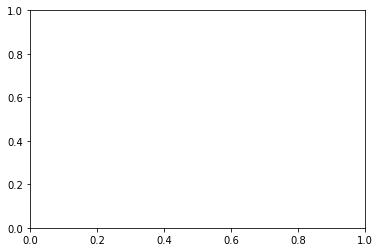

In [118]:
strats = list(stratScores.keys())
scores = list(stratScores.values())
cumScores = [[np.cumsum(ls[:i]) for i in range(len(ls))] for ls in scores]

plt.plot(cumScores)
plt.show()